In [2]:
import numpy as np
import sympy as sp

%matplotlib nbagg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pyJHTDB
from pyJHTDB import libJHTDB
from pyJHTDB.dbinfo import interpolation_code
from pyJHTDB.dbinfo import channel as info

import pickle

/Users/tdrivas/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [ ]:
nu = 5e-5
Prandtl = 1
kappa = nu/Prandtl
kolmogorov_time = 1e-3
kolmogorov_length = 1


Lx = info['lx']
Ly = info['ly']
Lz = info['lz']

Top = Ly/2
Bottom = -Ly/2

eps = Ly/100

npoints = 1
nparticles = 20
nsteps = info['time'].shape[0]
nsteps = nsteps


x         = np.zeros(shape = (npoints, nparticles, 3), dtype = np.float32)
x[..., 0] = Lx*np.random.random(size = (npoints,))[:, None]
x[..., 1] = info['ynodes'][info['ynodes'].shape[0]//25]
x[..., 2] = Lz*np.random.random(size = (npoints,))[:, None]


xfull      = np.zeros(shape = (nsteps+1, npoints, nparticles, 1), dtype = np.float32)
localtimeL = np.zeros(shape = (nsteps+1, npoints, nparticles), dtype = np.float32)
localtimeR = np.zeros(shape = (nsteps+1, npoints, nparticles), dtype = np.float32)

In [ ]:
lJHTDB = libJHTDB()
lJHTDB.initialize()

T = info['time'][-1];
subdivisions = 2
t = np.linspace(info['time'][-1], info['time'][0], num=subdivisions*nsteps+1)
tau = t[0]-t
xfull      = np.zeros(shape = (subdivisions*nsteps+1, npoints, nparticles, 3), dtype = np.float32)
localtimeL = np.zeros(shape = (subdivisions*nsteps+1, npoints, nparticles), dtype = np.float32)
localtimeR = np.zeros(shape = (subdivisions*nsteps+1, npoints, nparticles), dtype = np.float32)

xfull[0] = x
for tindex in range(subdivisions*nsteps):
    print('step {0}'.format(tindex))
    # get velocity
    u = lJHTDB.getData(
                t[tindex],
                xfull[tindex],
                sinterp = interpolation_code['M2Q8'],
                tinterp = interpolation_code['NoTInt'],
                data_set = info['name'],
                getFunction = 'getVelocity')
    # Euler Maruyama with Reflection
    dt = t[tindex]-t[tindex+1]
    dW = np.random.randn(*xfull.shape[1:])*np.sqrt(dt)
    dX =  - u*dt + np.sqrt(2*kappa)*dW
    xfull[tindex+1] = xfull[tindex] + dX
    localtimeL[tindex+1] = localtimeL[tindex] 
    localtimeR[tindex+1] = localtimeR[tindex] 
    for k in range(npoints):
        for j in range(nparticles):
            if xfull[tindex][k,j,1] < Bottom + eps:
                VV = -2*dt*np.log(np.random.rand());
                Y = (-dX[k,j,:]+np.sqrt(2*kappa*VV+dX[k,j,:]**2))/2;
                dL = max(0, Y[1] - xfull[tindex][k,j,1] + Bottom);
                xfull[tindex+1][k,j,1] = xfull[tindex][k,j,1] + dL 
                localtimeL[tindex+1][k,j] = localtimeL[tindex+1][k,j] + dL/kappa
            if xfull[tindex][k,j,1] > Top - eps:
                VV = -2*dt*np.log(np.random.rand());
                Y = (dX[k,j,:]+np.sqrt(2*kappa*VV+dX[k,j,:]**2))/2;
                dL = max(0, Y[1] + xfull[tindex][k,j,1] - Top);
                xfull[tindex+1][k,j,1] = xfull[tindex][k,j,1] - dL 
                localtimeR[tindex+1][k,j] = localtimeR[tindex+1][k,j] + dL/kappa
            xfull[tindex+1][k,j,1]=max(min(xfull[tindex+1][k,j,1],Top),Bottom); 
lJHTDB.finalize()

step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
step 37
step 38
step 39
step 40
step 41
step 42
step 43
step 44
step 45
step 46
step 47
step 48
step 49
step 50
step 51
step 52
step 53
step 54
step 55
step 56
step 57
step 58
step 59
step 60
step 61
step 62
step 63
step 64
step 65
step 66
step 67
step 68
step 69
step 70
step 71
step 72
step 73
step 74
step 75
step 76
step 77
step 78
step 79
step 80

In [9]:
####### Dump Data #######

pickle.dump(xfull, open( "data_channel/xfull.p", "wb" ) )
pickle.dump(t, open( "data_channel/t.p", "wb" ) )
pickle.dump(localtimeL, open( "data_channel/LL.p", "wb" ) )
pickle.dump(localtimeR, open( "data_channel/LR.p", "wb" ) )

####### Load Data #######

xfull = pickle.load( open( "data_channel/xfull.p", "rb" ) )
t = pickle.load( open( "data_channel/t.p", "rb" ) )
localtimeL = pickle.load( open( "data_channel/LL.p", "rb" ) )
localtimeR = pickle.load( open( "data_channel/LR.p", "rb" ) )

<IPython.core.display.Javascript object>


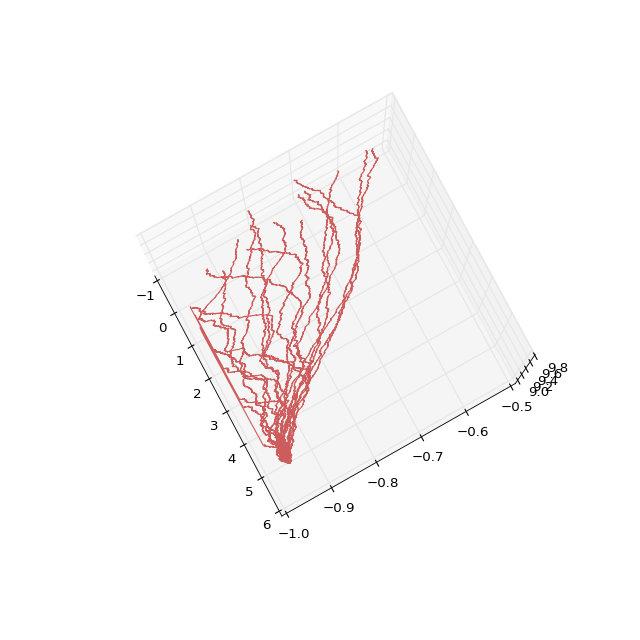

In [21]:
molecular_traj = xfull1
space_indx = 0
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection = '3d')
for traj in range(xfull.shape[2]):
    ax.plot(molecular_traj[:, space_indx, traj, 0],
            molecular_traj[:, space_indx, traj, 1],
            molecular_traj[:, space_indx, traj, 2],
            color = 'Indianred')

<IPython.core.display.Javascript object>


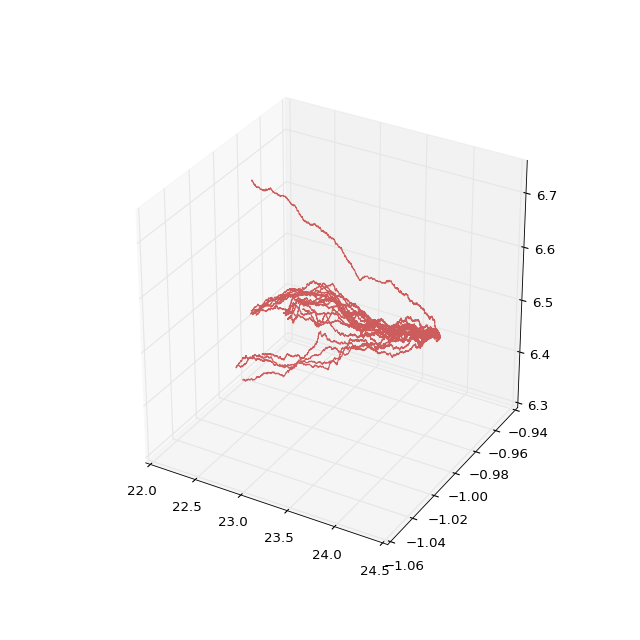

In [17]:
molecular_traj = xfull
space_indx = 0
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection = '3d')
for traj in range(xfull.shape[2]):
    ax.plot(molecular_traj[:, space_indx, traj, 0],
            molecular_traj[:, space_indx, traj, 1],
            molecular_traj[:, space_indx, traj, 2],
            color = 'Indianred')

In [8]:
print np.max(localtimeL)
print np.max(localtimeR)
print xfull[0, 0, 3, 0]
print xfull[0, 0, 3, 1]
print xfull[0, 0, 3, 2]

0.0
0.0
24.2831
-0.992807
6.52028


<IPython.core.display.Javascript object>


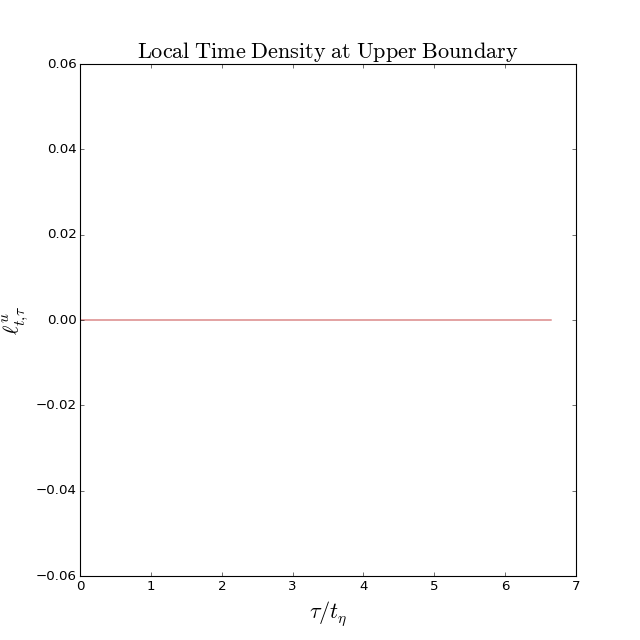

In [21]:
molecular_traj = xfull
indx = 0
particleindx = 2
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(tau,localtimeR[:, indx, particleindx],color = 'Indianred')
ax.set_title('$\\rm Local\ Time\ Density\ at\ Upper\ Boundary$', fontsize=20)
ax.set_xlabel('$\\tau / t_\\eta$', fontsize=20)
ax.set_ylabel('$\\ell^u_{t,\\tau}$', fontsize=20)

<IPython.core.display.Javascript object>


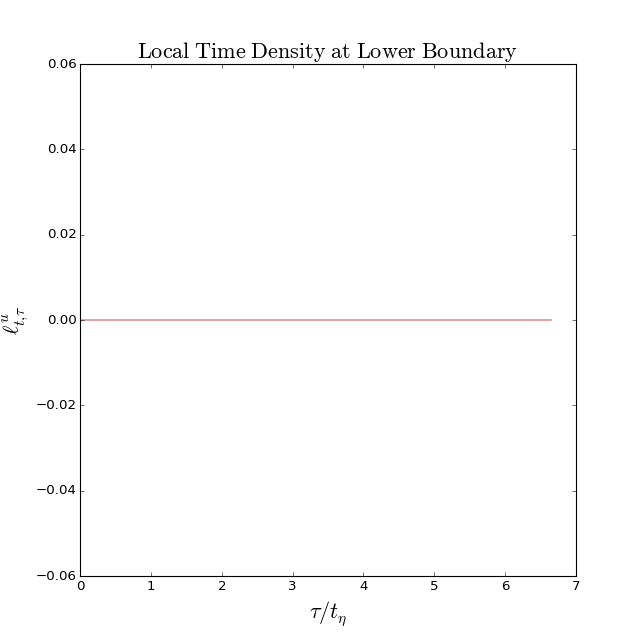

In [22]:
molecular_traj = xfull
indx = 0
particleindx = 1
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(tau,localtimeL[:, indx, particleindx],color = 'Indianred')
ax.set_title('$\\rm Local\ Time\ Density\ at\ Lower\ Boundary$', fontsize=20)
ax.set_xlabel('$\\tau / t_\\eta$', fontsize=20)
ax.set_ylabel('$\\ell^u_{t,\\tau}$', fontsize=20)

In [33]:
from scipy.special import erf
def localTimePDF(x):
    return 2*erf(x/4*(Bottom-Top))-1

time_index = len(t)-1
ELL   = np.zeros(npoints)
ELR   = np.zeros(npoints)
VarLL = np.zeros(npoints)
VarLR = np.zeros(npoints)
CovL  = np.zeros(npoints)
for i in range(npoints):
    localtimeL_Ave = np.average(localtimeL, axis = 2)
    localtimeR_Ave = np.average(localtimeR, axis = 2)
    localtimeL_Var = np.average(localtimeL**2, axis = 2)         - localtimeL_Ave**2
    localtimeR_Var = np.average(localtimeR**2, axis = 2)         - localtimeR_Ave**2
    localtime_Cov  = np.average(localtimeR*localtimeL, axis = 2) - localtimeR_Ave*localtimeL_Ave
    ELL[i]   = localtimeL_Ave[time_index, i,0]
    ELR[i]   = localtimeR_Ave[time_index, i,0]
    VarLL[i] = localtimeL_Var[time_index, i,0]
    VarLR[i] = localtimeR_Var[time_index, i,0]
    CovL[i]  = localtime_Cov[time_index,  i,0]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


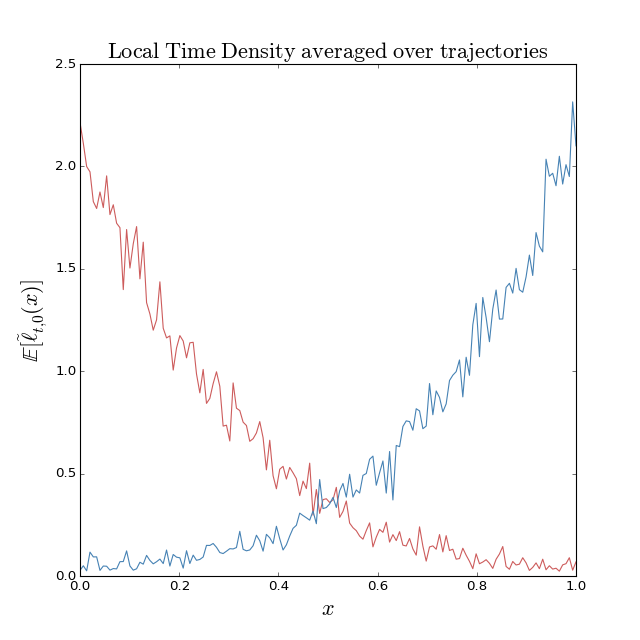

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


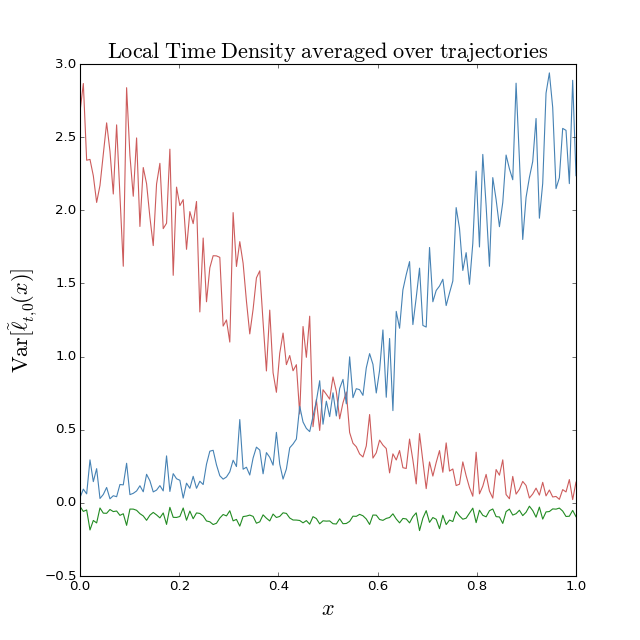

In [34]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(xx, ELL, color = 'Indianred')
ax.plot(xx, ELR, color = 'Steelblue')
ax.set_xlim([Top,Bottom])
ax.set_title('$\\rm Local\ Time\ Density\ averaged \ over \ trajectories$', fontsize=20)
ax.set_xlabel('$x$', fontsize=20)
ax.set_ylabel('$\\mathbb{E}[\\tilde{\\ell}_{t,0}(x)]$', fontsize=20)


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(xx, VarLL, color = 'Indianred')
ax.plot(xx, VarLR, color = 'Steelblue')
ax.plot(xx, CovL, color = 'Forestgreen')
ax.set_xlim([Top,Bottom])
ax.set_title('$\\rm Local\ Time\ Density\ averaged \ over \ trajectories$', fontsize=20)
ax.set_xlabel('$x$', fontsize=20)
ax.set_ylabel('${\\rm Var}[\\tilde{\\ell}_{t,0}(x)]$', fontsize=20)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


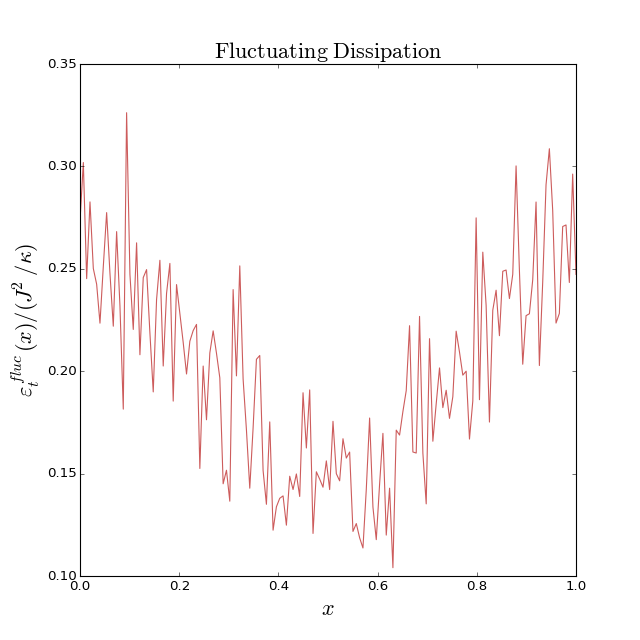

In [41]:
J=1
FluctuatingDissipation = VarLL + VarLR - CovL
FluctuatingDissipation = FluctuatingDissipation/(J**2/kappa)


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(xx, FluctuatingDissipation, color = 'Indianred')
ax.set_xlim([Top,Bottom])
ax.set_title('$\\rm Fluctuating\ Dissipation$', fontsize=20)
ax.set_xlabel('$x$', fontsize=20)
ax.set_ylabel('$\\varepsilon_t^{fluc}(x)/(J^2/\kappa)$', fontsize=20)